In [1]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
library(glmnet)


Loading required package: Matrix

Loaded glmnet 4.1-8



In [3]:
glm_results <- readRDS("glm_result.rds")


In [4]:
mse_lasso <- sapply(glm_results, function(x) x$mse_lasso)
mse_glm <- sapply(glm_results, function(x) x$mse_glm)


In [5]:
str(glm_results[1])

List of 1
 $ MPPED2:List of 6
  ..$ gene             : chr "MPPED2"
  ..$ glm_coefs        : Named num [1:17] -2.7846 0.0527 0.3793 -0.0121 -0.7721 ...
  .. ..- attr(*, "names")= chr [1:17] "(Intercept)" "chr11.30107972.30108172" "chr11.30196693.30196893" "chr11.30322963.30323163" ...
  ..$ lasso_coefs      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:8] 0 2 6 7 8 11 12 13
  .. .. ..@ p       : int [1:2] 0 8
  .. .. ..@ Dim     : int [1:2] 17 1
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:17] "(Intercept)" "chr11:30107972-30108172" "chr11:30196693-30196893" "chr11:30322963-30323163" ...
  .. .. .. ..$ : chr "s1"
  .. .. ..@ x       : num [1:8] -2.743 0.245 0.227 0.875 0.209 ...
  .. .. ..@ factors : list()
  ..$ mse_glm          : num 0.184
  ..$ mse_lasso        : num 0.183
  ..$ num_nonzero_coefs: int 8


In [6]:
glm_results[[1]]$glm_coefs %>% length()

[1] 17

In [7]:
num_coefficients <- sapply(glm_results, function(x) x$num_nonzero_coefs)
tested_coefficients <- sapply(glm_results, function(x) length(x$glm_coefs))



In [8]:
num_peaks <- cbind(tested_coefficients,num_coefficients) %>% as.data.frame()
num_peaks <- num_peaks %>% mutate(fraction =num_coefficients/tested_coefficients,
                      mse_diff = mse_glm-mse_lasso)

In [9]:
num_peaks_sorted <- num_peaks %>% arrange(desc(tested_coefficients))

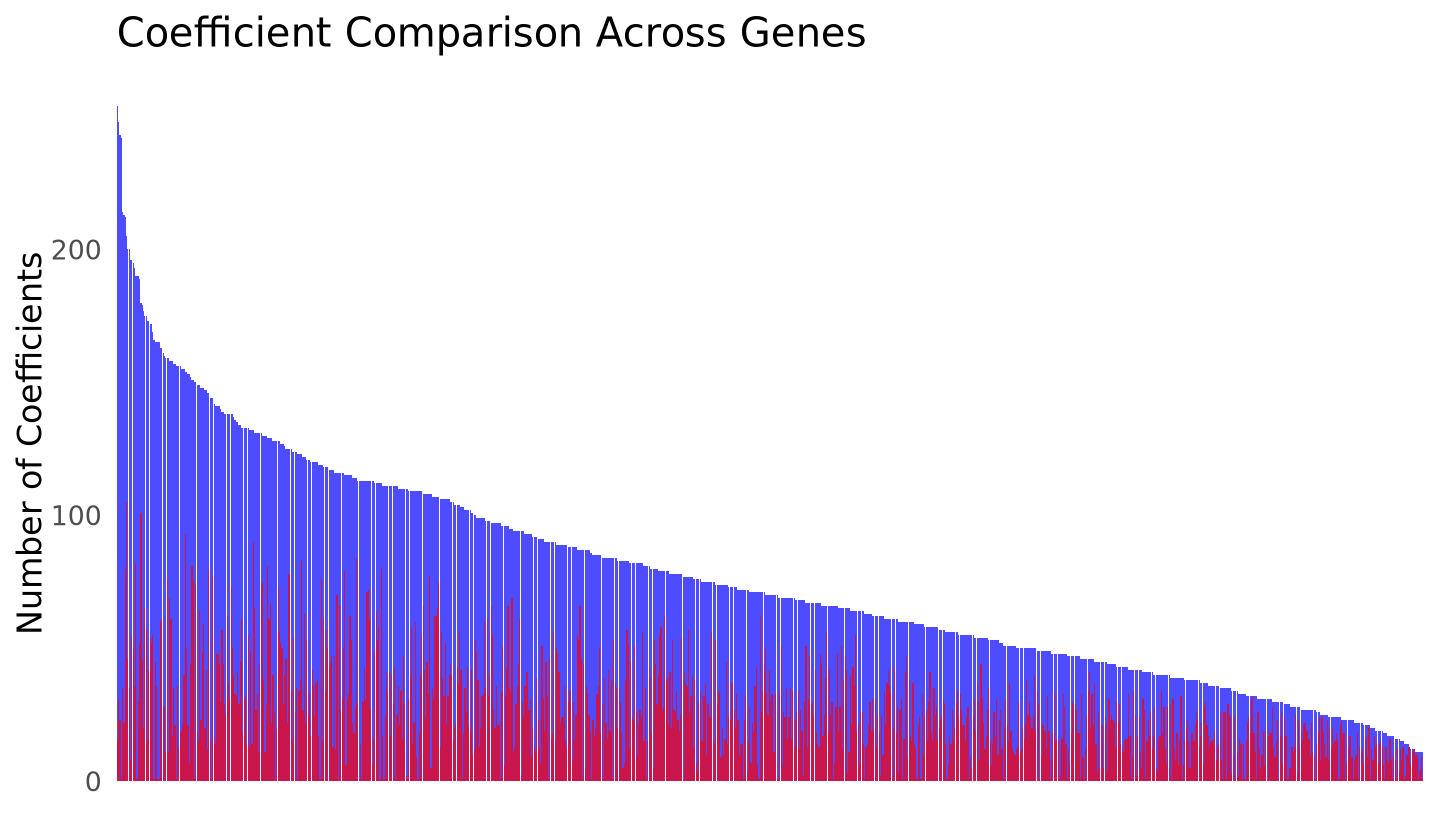

In [10]:
options(repr.plot.width=12)
library(ggplot2)
num_peaks_sorted$gene <- factor(rownames(num_peaks_sorted), levels = rownames(num_peaks_sorted))

# Create stacked bar plot
ggplot(num_peaks_sorted, aes(x = gene)) +
  geom_bar(aes(y = tested_coefficients, fill = "Total Peaks (GLM)"), 
           stat = "identity", position = "identity", alpha = 0.7) +
  geom_bar(aes(y = num_coefficients, fill = "Non-zero Coefficients (Lasso)"), 
           stat = "identity", position = "identity", alpha = 0.7) +
  scale_fill_manual(values = c("Total Peaks (GLM)" = "blue", 
                                "Non-zero Coefficients (Lasso)" = "red")) +
  labs(title = "Coefficient Comparison Across Genes",
       x = NULL,  # Removes x-axis title
       y = "Number of Coefficients",
       fill = "Coefficient Type") +
  ylim(0, NA) +  # Removes the plot area below zero
  theme_minimal(base_size=20) +
  theme(axis.text.x = element_blank(),  # Removes x-axis labels
        axis.title.x = element_blank(), # Removes x-axis title
        panel.grid.minor = element_blank(),  # Remove minor grid lines
        panel.grid.major = element_blank(),  # Remove major grid lines
        panel.background = element_blank(),  # Remove panel background
        legend.position = "none")  # Positions the legend at the top

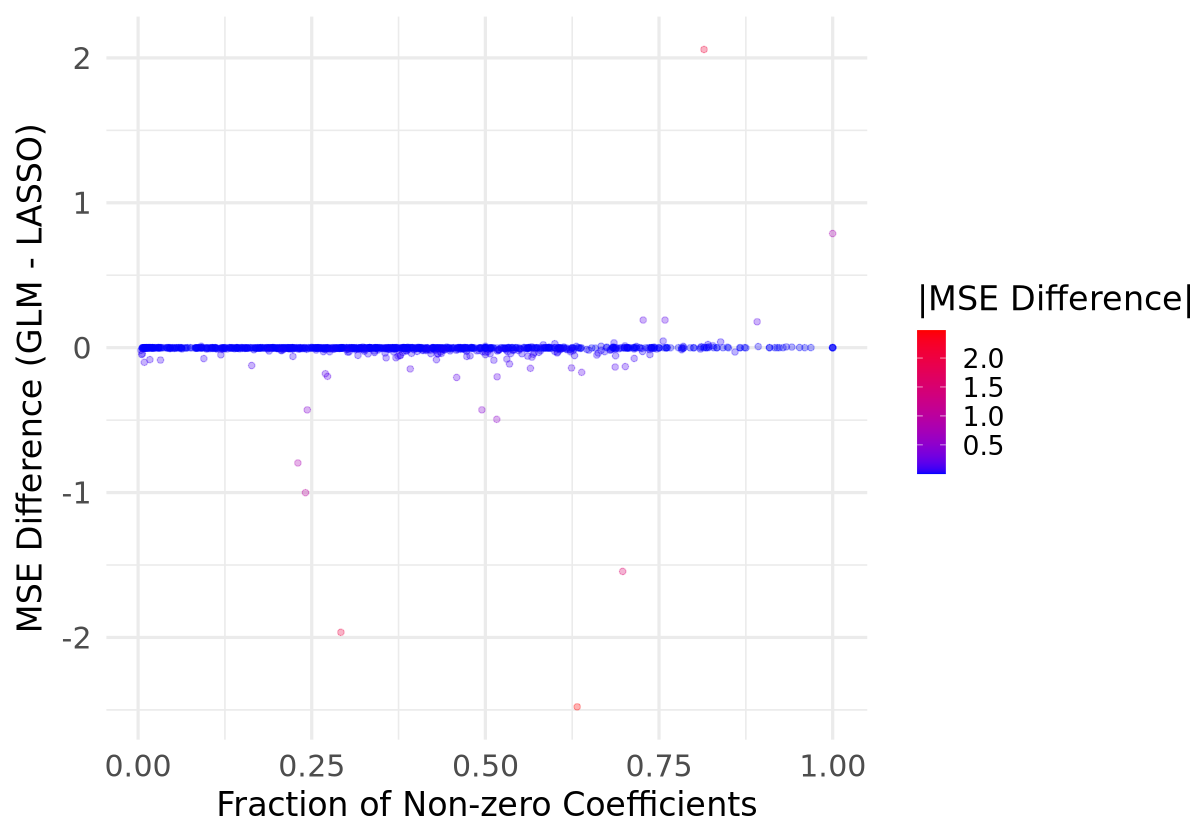

In [52]:
library(ggplot2)
library(scales)

options(repr.plot.width=10)
# Updated plot with enhancements
num_peaks %>% filter(abs(mse_diff) <=2.6) %>% 
ggplot(aes(x = fraction, y = mse_diff)) +
  geom_point(aes(color = abs(mse_diff)), alpha = 0.3) + # Color by |mse_diff|
  scale_color_gradient(low = "blue", high = "red", name = "|MSE Difference|") + 
  #geom_hline(yintercept = 0, linetype = "dashed", color = "gray", size = 0.8) +
  labs(
    #title = "Sparsity vs MSE Difference",
    x = "Fraction of Non-zero Coefficients", 
    y = "MSE Difference (GLM - LASSO)"
  ) +
  #ylim(-2.5, 2.5) + # Keep the y-limit for comparability
  theme_minimal(base_size = 20) + 
  theme(
    legend.position = "right",
    #plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 18)
  )


In [15]:
new_tss <- read.table("GeneBody_500kb_margin.bed")
colnames(new_tss) <- c("chromosome","start","end","gene_symbol")

In [16]:
new_tss <- new_tss %>%
  mutate(
    start = pmax(0, start - 500000),
    end = pmax(0, end - 500000)
  )

new_tss

chromosome,start,end,gene_symbol
<chr>,<dbl>,<dbl>,<chr>
chr1,0,31109,MIR1302-2HG
chr1,0,36081,FAM138A
chr1,0,71585,OR4F5
chr1,0,451697,OR4F29
chr1,0,686673,OR4F16
chr1,0,810065,LINC01409
chr1,0,819837,FAM87B
chr1,0,868202,LINC01128
chr1,0,827522,LINC00115


In [17]:
glm_results <- lapply(glm_results, function(gene_data) {
  # Modify rownames of lasso_coefs by replacing ":" and "-" with "."
  new_rownames <- gsub(":|-", ".", rownames(gene_data$lasso_coefs))
  
  # Assign the new rownames to lasso_coefs
  rownames(gene_data$lasso_coefs) <- new_rownames
  
  # Return the updated gene data
  return(gene_data)
})

In [18]:
library(dplyr)
library(stringr)

# Function to extract peak locations from peak names
extract_peak_location <- function(peak_names) {
  split_peaks <- str_split(peak_names, "\\.")

  # Create the dataframe
  peak_df <- data.frame(
    chr = sapply(split_peaks, function(x) x[1]),          # Extract chromosome (chr11)
    start = as.numeric(sapply(split_peaks, function(x) x[2])), # Extract start position
    end = as.numeric(sapply(split_peaks, function(x) x[3]))   # Extract end position
  )

  return(peak_df)
}

calculate_distance_to_tss <- function(peak_names, tss_df, gene_name) {
  peak_df <- extract_peak_location(peak_names) # Extract peak info
  
  # Add a column for peak midpoints
  peak_df$midpoint <- (peak_df$start + peak_df$end) / 2
  
  # Initialize a column to store distances
  peak_df$distance_to_tss <- NA
  
  # Loop over each peak to calculate distance to TSS for the specific gene
  for (i in 1:nrow(peak_df)) {
    # Get the TSS for the specified gene
    tss_match <- tss_df %>% 
      filter(gene_symbol == gene_name)
      #print(tss_match)
    
    # Calculate distance to TSS if there's a match
    #if (nrow(tss_match) > 0) {
    #  if (tss_match$strand[1] == "+") {
    #    peak_df$distance_to_tss[i] <- peak_df$midpoint[i] - tss_match$tss[1]
    #  } else {
    #    peak_df$distance_to_tss[i] <- tss_match$tss[1] - peak_df$midpoint[i]
    #  }

    peak_df$distance_to_tss[i] <- min(abs(tss_match$start - peak_df$midpoint[i]),
                                      (abs(tss_match$end - peak_df$midpoint[i])))
    }
  
  
  return(peak_df)
}

# Combine GLM results with TSS information
get_peak_gene_distances <- function(glm_results, tss_df) {
  distance_results <- lapply(names(glm_results), function(gene_name) {
    # Get current gene's TSS info
    #gene_tss <- tss_df %>% 
    #  filter(gene_symbol == gene_name) %>%
    #  select(chromosome, tss)
    
    # Get peak info and coefficients
    peak_names <- names(glm_results[[gene_name]]$glm_coefs)[-1]  # Exclude intercept
    peak_locations <- extract_peak_location(peak_names)  # Extract peak information

    # Handle potential mismatches in coefficient lengths
    glm_coefs <- glm_results[[gene_name]]$glm_coefs[-1]  # Exclude intercept
    lasso_coefs <- glm_results[[gene_name]]$lasso_coefs[names(glm_coefs),]

    # Create a full vector for lasso coefs (set to 0 where necessary)
    #lasso_coef_vector <- rep(0, length(peak_names))
    #names(lasso_coef_vector) <- peak_names
    
    # Assign the non-zero lasso coefficients
    lasso_coef_vector <- lasso_coefs
    
    # Ensure consistent length (take the minimum length)
    min_length <- min(nrow(peak_locations), length(glm_coefs), length(lasso_coef_vector))

    # Calculate distance to TSS using the updated function for the specific gene
    peak_locations <- calculate_distance_to_tss(peak_names, tss_df, gene_name)  # Calculate distance to TSS
    
    # Add gene and coefficient information to the data frame
    peak_locations$gene <- gene_name
    peak_locations$glm_coef <- glm_coefs
    peak_locations$lasso_coef <- lasso_coef_vector
    peak_locations$is_lasso_selected <- peak_locations$lasso_coef != 0
    
    return(peak_locations)
  })
  
  # Combine the list of results into one data frame
  result_df <- do.call(rbind, distance_results)
  
  return(result_df)
}


In [19]:
peak_gene <- get_peak_gene_distances(glm_results, new_tss)

In [20]:
scent_obj <- readRDS("fibroblast_SCENT_no_covariates.rds")

In [21]:
peak_gene <- peak_gene %>% mutate(gene_count = rowSums(scent_obj@rna)[gene])

In [22]:
peak_gene <- peak_gene %>% mutate(percent_expressed = (rowSums(scent_obj@rna>1)/9902)[gene]*100)

In [23]:
peak_sums <- rowSums(scent_obj@atac)

In [24]:
peak_percentage <- (rowSums(scent_obj@atac>1)/9902)*100

In [25]:
peak_percentage %>% head()

chr1:817238-817438 chr1:827432-827632 chr1:869776-869976 chr1:904365-904565 
         0.3736619          0.7978186          1.0502929          0.4140578 
chr1:904661-904861 chr1:905315-905515 
         2.8580085          0.3635629

In [26]:
names(peak_sums) <- gsub(":|-",".",names(peak_sums))

In [27]:
names(peak_percentage) <- gsub(":|-",".",names(peak_percentage))

In [28]:
peak_gene <- peak_gene %>% mutate(peak=paste(chr,start,end,sep="."))
head(peak_gene)

,chr,start,end,midpoint,distance_to_tss,gene,glm_coef,lasso_coef,is_lasso_selected,gene_count,percent_expressed,peak
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>
1,chr11,30107972,30108172,30108072,478800,MPPED2,0.05273206,0.0000000,FALSE,769,1.696627,chr11.30107972.30108172
2,chr11,30196693,30196893,30196793,390079,MPPED2,0.37932546,0.2449123,TRUE,769,1.696627,chr11.30196693.30196893
3,chr11,30322963,30323163,30323063,263809,MPPED2,-0.01211070,0.0000000,FALSE,769,1.696627,chr11.30322963.30323163
4,chr11,30326456,30326656,30326556,260316,MPPED2,-0.77213044,0.0000000,FALSE,769,1.696627,chr11.30326456.30326656
5,chr11,30342757,30342957,30342857,244015,MPPED2,-12.40600213,0.0000000,FALSE,769,1.696627,chr11.30342757.30342957
6,chr11,30346189,30346389,30346289,240583,MPPED2,0.45012454,0.2274808,TRUE,769,1.696627,chr11.30346189.30346389


In [29]:
peak_gene <- peak_gene %>% mutate(peak_count = peak_sums[peak])

In [30]:
peak_gene <- peak_gene %>% mutate(peak_percent = peak_percentage[peak])

In [31]:
peak_gene$percent_peak <- NULL

In [32]:
peak_sums %>% head()

chr1.817238.817438 chr1.827432.827632 chr1.869776.869976 chr1.904365.904565 
               709               1140               1159                534 
chr1.904661.904861 chr1.905315.905515 
              2236                507

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


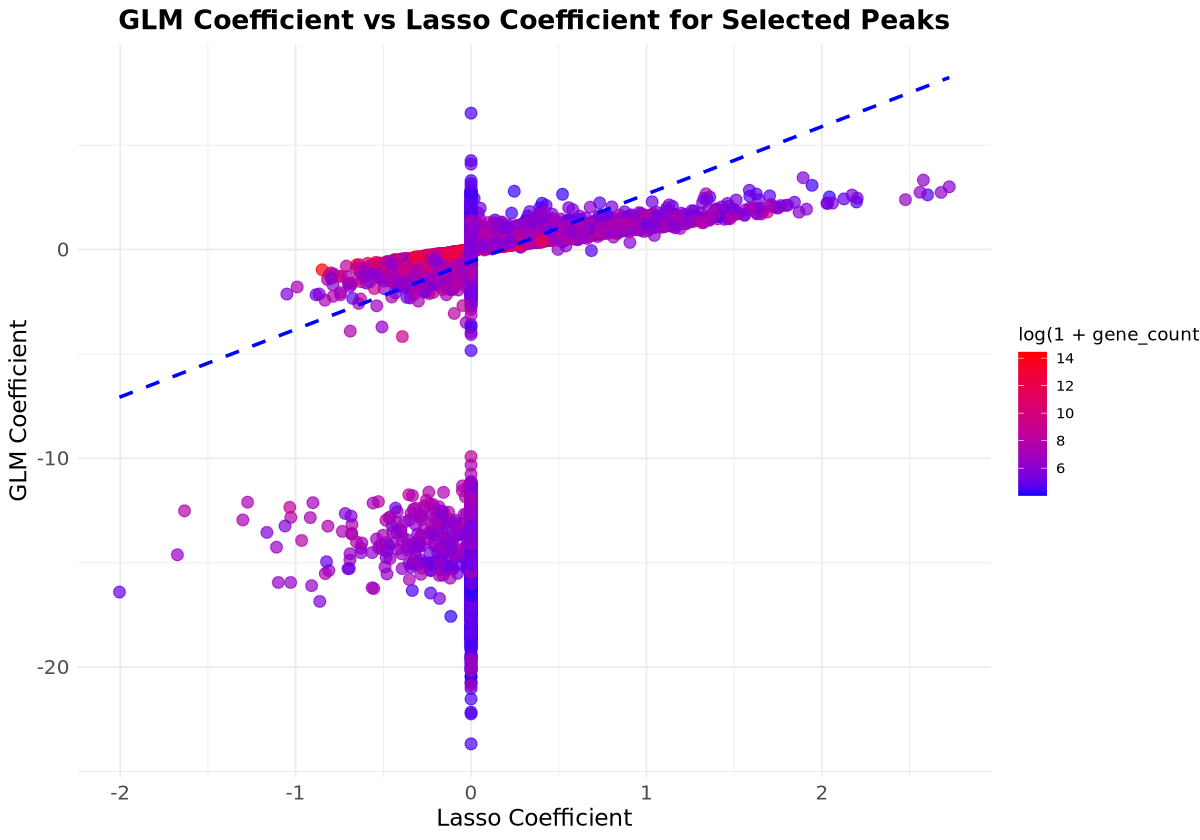

In [34]:
library(ggplot2)

peak_gene %>%
  #filter(is_lasso_selected & (glm_coef > 0)) %>%
  ggplot(aes(x = lasso_coef, y = glm_coef)) +
  geom_point(aes(color = log(1+gene_count)), alpha = 0.7, size = 3) +  # Add transparency and color based on glm_coef
  geom_smooth(method = "lm", se = FALSE, color = "blue", linetype = "dashed", size = 1) +  # Regression line
  scale_color_gradient(low = "blue", high = "red") +  # Gradient color scale
  labs(
    title = "GLM Coefficient vs Lasso Coefficient for Selected Peaks",
    x = "Lasso Coefficient",
    y = "GLM Coefficient"
  ) +
  theme_minimal() +  # Minimal theme
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),  # Center and style title
    axis.title = element_text(size = 14),  # Axis labels size
    axis.text = element_text(size = 12)  # Axis text size
  )  # Set limits for x and y axes

In [33]:
peak_gene <- peak_gene %>% filter(abs(distance_to_tss) < 500000)

In [34]:
peak_gene <- peak_gene %>% 
  mutate(abs_distance = abs(distance_to_tss / 1e3),  # Convert distance to kb
         distance_bin = floor(abs_distance))  # Create 1kb bins
         


In [35]:
peak_gene <- filter(peak_gene,abs_distance <= 500)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


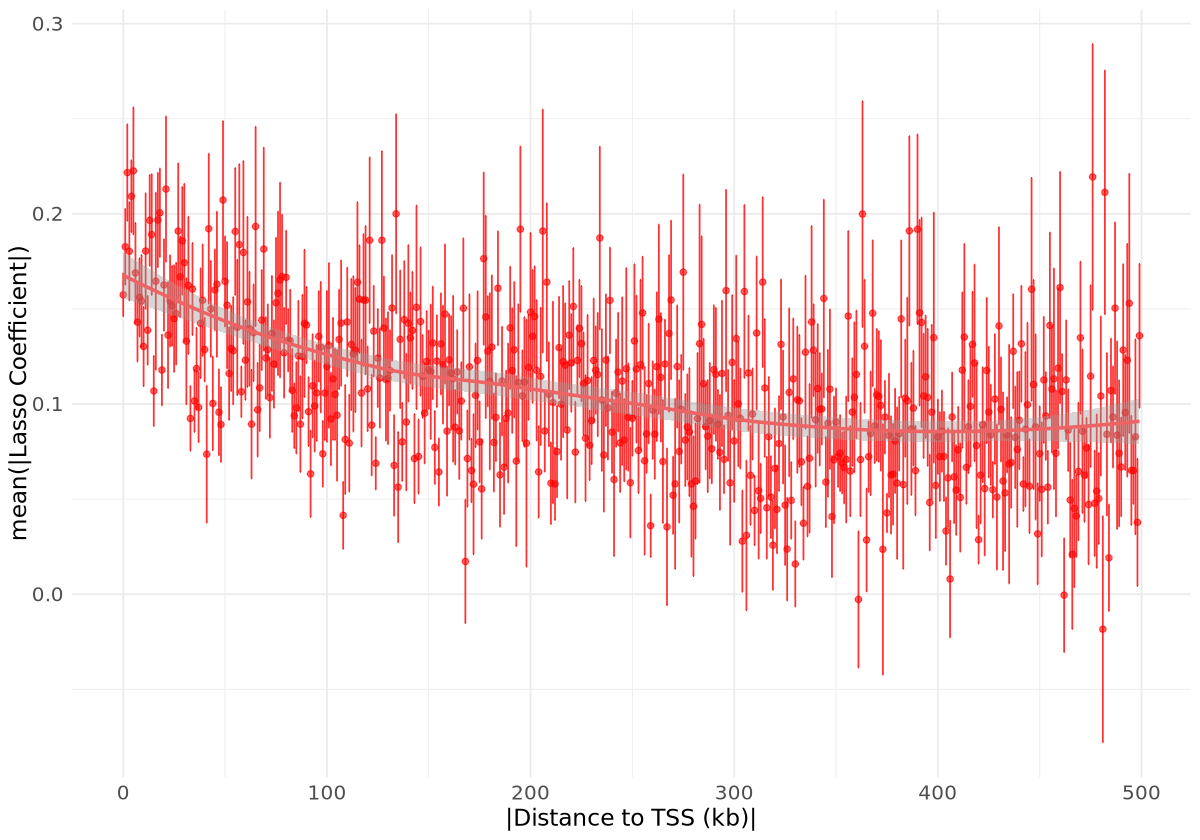

In [36]:
# Calculate mean and standard error for Lasso Coefficient in each 1kb bin
mean_peak_gene <- peak_gene %>% 
  filter(is_lasso_selected) %>% 
  group_by(distance_bin) %>%
  summarize(
    mean_lasso_coef = mean(lasso_coef, na.rm = TRUE),
    se_lasso_coef = sd(lasso_coef, na.rm = TRUE) / sqrt(n()), # Standard error
    .groups = 'drop'
  )

# Plot Mean Lasso Coefficient vs Distance Bin with Error Bars
ggplot(mean_peak_gene, aes(x = distance_bin, y = mean_lasso_coef)) +
  geom_point(color = "red", alpha = 0.6) +
  geom_errorbar(aes(ymin = mean_lasso_coef - se_lasso_coef, 
                    ymax = mean_lasso_coef + se_lasso_coef), 
                width = 0.5, color = "red", alpha = 0.8) + # Add error bars
  geom_smooth(se = TRUE, color = "indianred2") +
  labs(
    x = "|Distance to TSS (kb)|",
    y = "mean(|Lasso Coefficient|)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12)
  )


In [37]:
mean_lasso <- peak_gene %>%
  filter(is_lasso_selected) %>% 
  group_by(distance_bin) %>%
  summarize(mean_lasso_coef = mean(abs(lasso_coef), na.rm = TRUE), .groups = 'drop') %>%
  mutate(type = "Lasso")


In [38]:
mean_lasso <- peak_gene %>%
  filter(is_lasso_selected) %>% 
  group_by(distance_bin) %>%
  summarize(mean_coef = mean(abs(lasso_coef), na.rm = TRUE), .groups = 'drop') %>%
  mutate(type = "Lasso")


In [39]:

# Calculate the mean GLM Coefficient for each 1kb bin
mean_glm <- peak_gene %>%
  group_by(distance_bin) %>%
  summarize(mean_coef = mean(abs(glm_coef), na.rm = TRUE), .groups = 'drop') %>%
  mutate(type = "GLM")


In [40]:
combined_means <- bind_rows(
  mean_lasso,mean_glm)

In [41]:
peak_gene %>% colnames

[1] "chr"               "start"             "end"              
 [4] "midpoint"          "distance_to_tss"   "gene"             
 [7] "glm_coef"          "lasso_coef"        "is_lasso_selected"
[10] "gene_count"        "percent_expressed" "peak"             
[13] "peak_count"        "peak_percent"      "abs_distance"     
[16] "distance_bin"

`geom_smooth()` using formula = 'y ~ x'


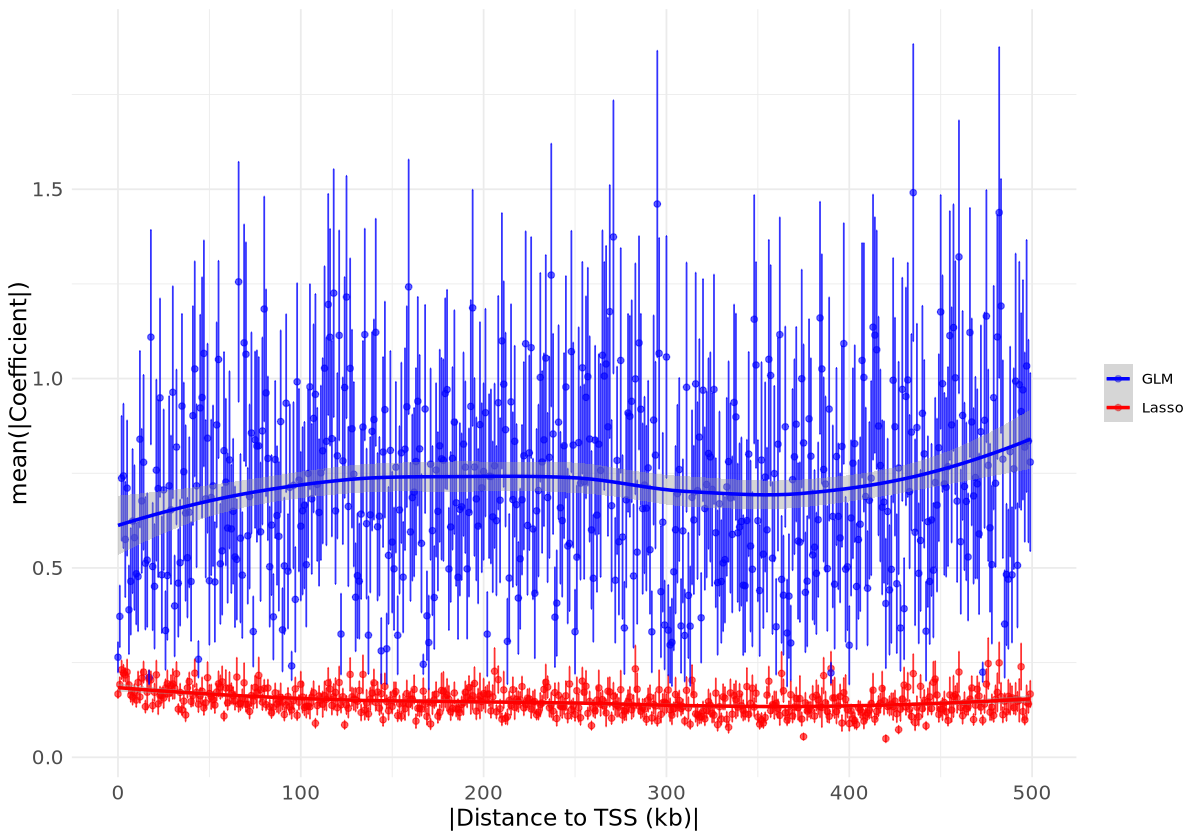

In [42]:
# Calculate the mean and standard error for Lasso Coefficients
mean_lasso <- peak_gene %>%
  filter(is_lasso_selected) %>% 
  group_by(distance_bin) %>%
  summarize(
    mean_coef = mean(abs(lasso_coef), na.rm = TRUE),
    se_coef = sd(abs(lasso_coef), na.rm = TRUE) / sqrt(n()), # Standard error
    .groups = 'drop'
  ) %>%
  mutate(type = "Lasso")

# Calculate the mean and standard error for GLM Coefficients
mean_glm <- peak_gene %>%
  group_by(distance_bin) %>%
  summarize(
    mean_coef = mean(abs(glm_coef), na.rm = TRUE),
    se_coef = sd(abs(glm_coef), na.rm = TRUE) / sqrt(n()), # Standard error
    .groups = 'drop'
  ) %>%
  mutate(type = "GLM")

# Combine the results
combined_means <- bind_rows(mean_lasso, mean_glm)

# Plot Mean Coefficients vs Distance Bin with Error Bars
ggplot(combined_means, aes(x = distance_bin, y = mean_coef, color = type)) +
  geom_point(alpha = 0.6) +
  geom_errorbar(
    aes(ymin = mean_coef - se_coef, ymax = mean_coef + se_coef), 
    width = 0.5, alpha = 0.8
  ) + # Add error bars
  geom_smooth(aes(group = type), method = "loess", se = TRUE) + # Separate smooth lines by type
  labs(
    x = "|Distance to TSS (kb)|",
    y = "mean(|Coefficient|)"
  ) +
  scale_color_manual(values = c("Lasso" = "red", "GLM" = "blue")) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.title = element_blank()
  )


`geom_smooth()` using formula = 'y ~ x'


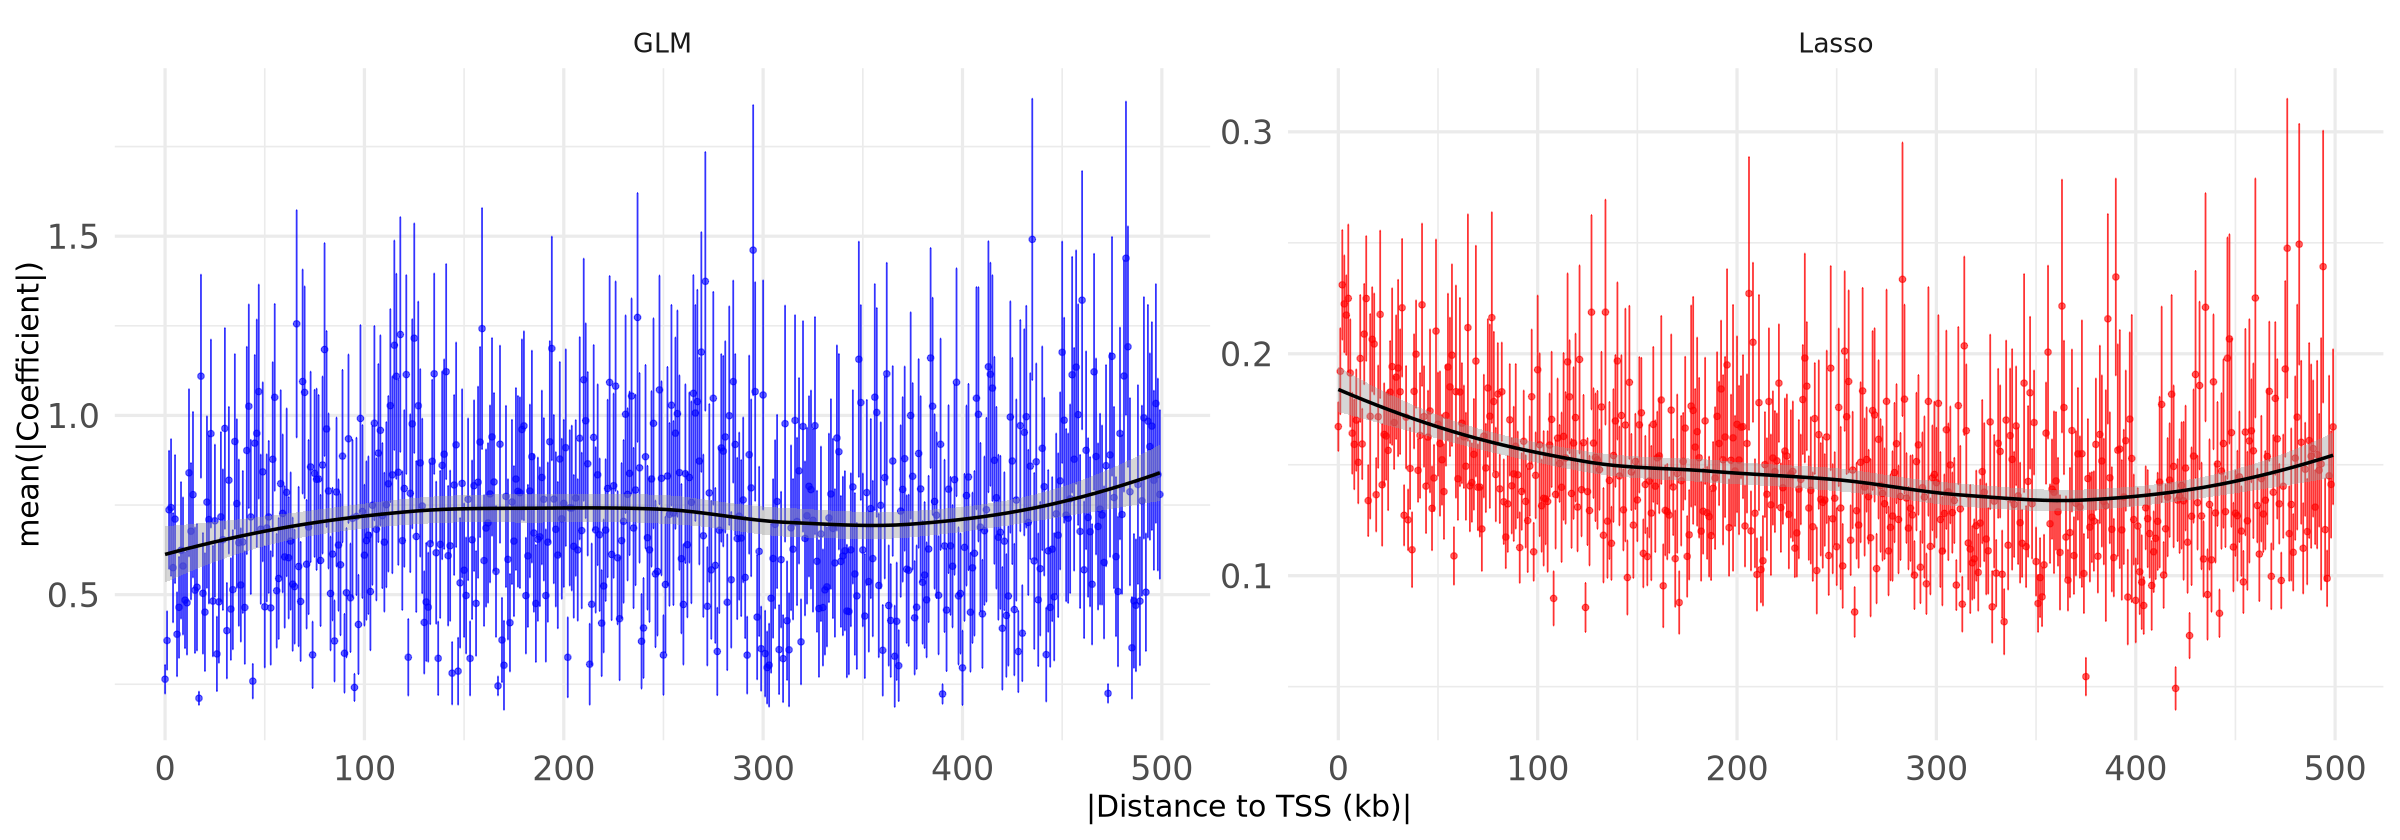

In [55]:
# Plot Mean Coefficients vs Distance Bin with Error Bars and Facet Wrap
options(repr.plot.width=20)
ggplot(combined_means, aes(x = distance_bin, y = mean_coef, color = type)) +
  geom_point(alpha = 0.6) +
  geom_errorbar(
    aes(ymin = mean_coef - se_coef, ymax = mean_coef + se_coef), 
    width = 0.5, alpha = 0.8
  ) + # Add error bars
  geom_smooth(method = "loess", se = TRUE, color = "black") + # Smooth line per facet
  labs(
    x = "|Distance to TSS (kb)|",
    y = "mean(|Coefficient|)"
  ) +
  scale_color_manual(values = c("Lasso" = "red", "GLM" = "blue")) +
  facet_wrap(~type, scales = "free_y") + # Facet wrap by type
  theme_minimal(base_size=20) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 20),
    legend.position = "none" # Remove legend (since type is now in facets)
  )


In [44]:
library(tidyr)


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


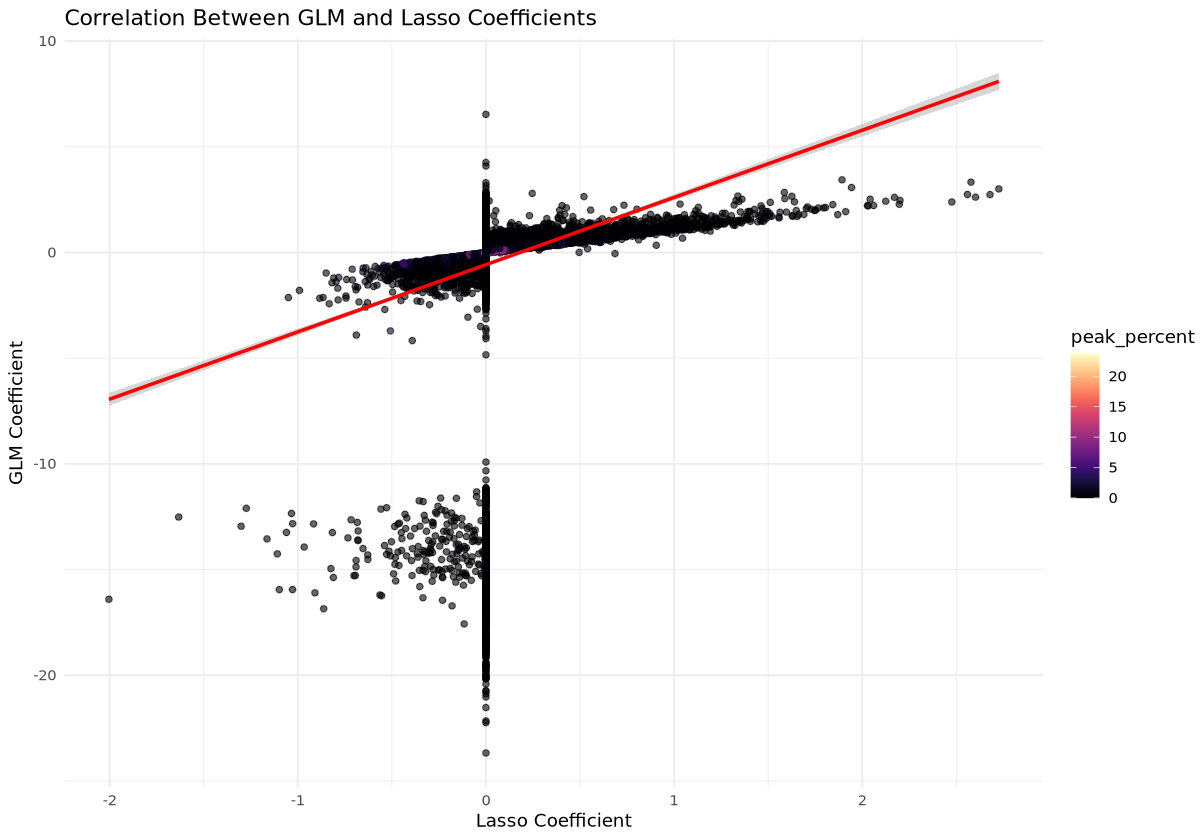

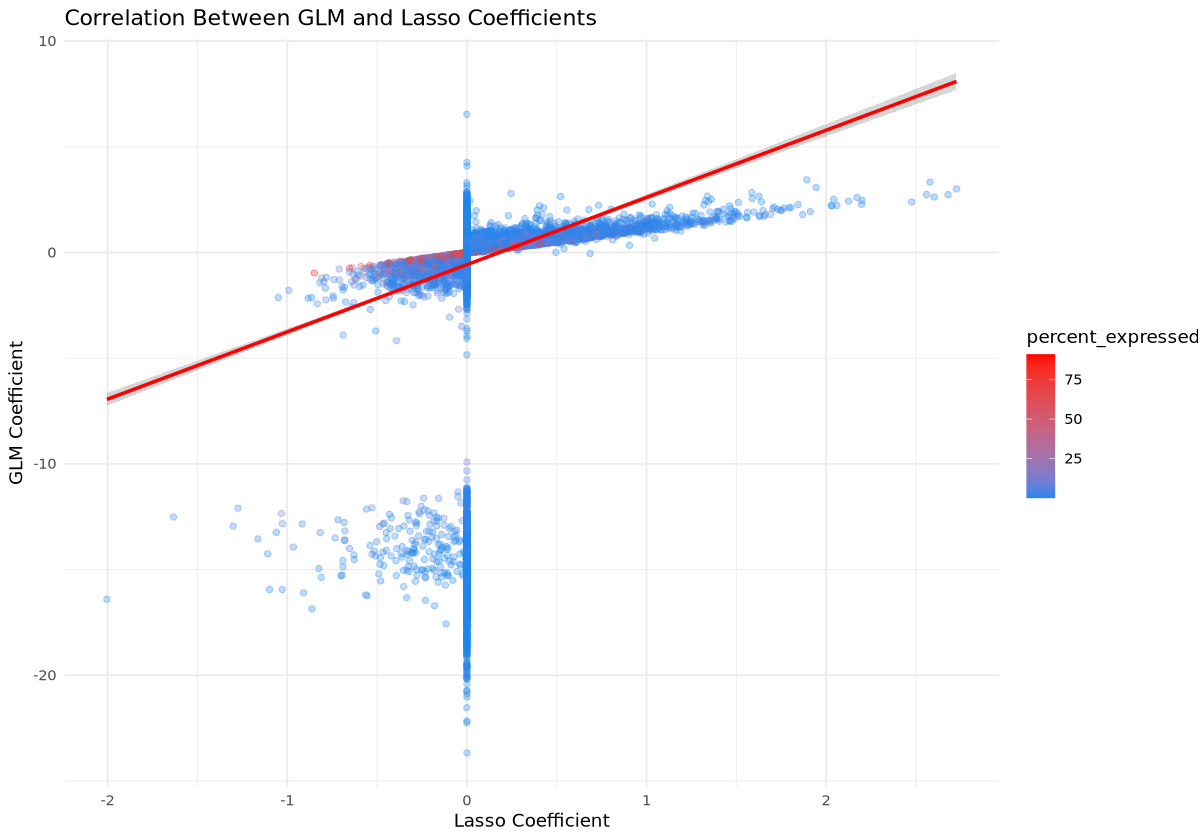

In [45]:
library(viridis)
ggplot(peak_gene, aes(y = glm_coef, x = lasso_coef, color = peak_percent)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", color = "red", se = TRUE) +
  labs(title = "Correlation Between GLM and Lasso Coefficients",
       y = "GLM Coefficient", 
       x = "Lasso Coefficient") +
  #scale_color_manual(values = c("TRUE" = "blue", "FALSE" = "gray")) +
  scale_color_viridis(option="A")+
  theme_minimal()

ggplot(peak_gene, aes(y = glm_coef, x = lasso_coef, color = percent_expressed)) +
  geom_point(alpha = 0.3) +
  geom_smooth(method = "lm", color = "red", se = TRUE) +
  labs(title = "Correlation Between GLM and Lasso Coefficients",
       y = "GLM Coefficient", 
       x = "Lasso Coefficient") +
       scale_color_gradient(low = "dodgerblue2", high = "red")+
  #scale_color_manual(values = c("TRUE" = "blue", "FALSE" = "gray")) +
  theme_minimal()

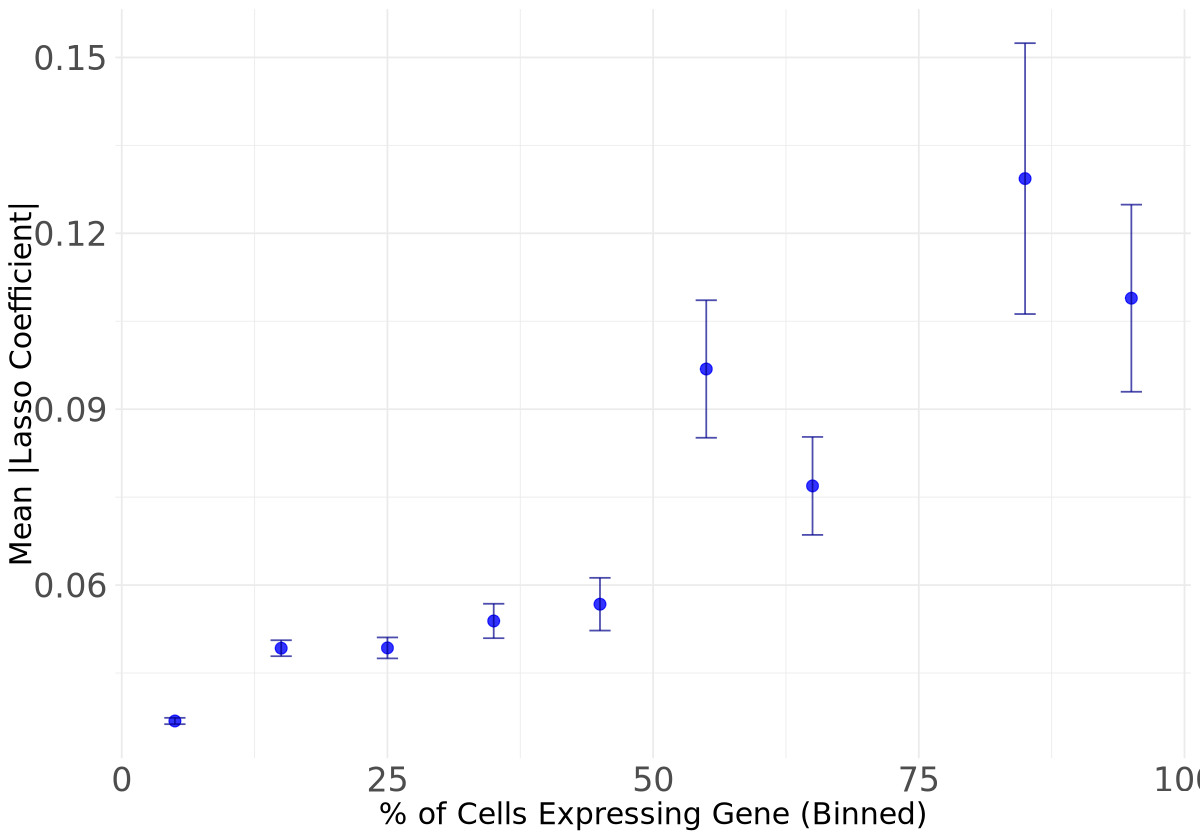

In [102]:
library(dplyr)
library(ggplot2)

# Bin the `percent_expressed` values into groups (e.g., 10% intervals)
binned_data <- peak_gene %>%
  mutate(percent_bin = cut(percent_expressed, 
                           breaks = seq(0, 100, by = 10), 
                           include.lowest = TRUE, 
                           labels = seq(5, 95, by = 10))) %>% # Assign bin midpoints as labels
  group_by(percent_bin) %>%
  summarize(
    mean_lasso_coef = mean(abs(lasso_coef), na.rm = TRUE),
    se_lasso_coef = sd(abs(lasso_coef), na.rm = TRUE) / sqrt(n()),
    .groups = 'drop'
  )

# Plot the binned averages with error bars
ggplot(binned_data, aes(x = as.numeric(as.character(percent_bin)), 
                        y = mean_lasso_coef)) +
  geom_point(color = "blue", alpha = 0.8, size = 3) +
  geom_errorbar(aes(ymin = mean_lasso_coef - se_lasso_coef, 
                    ymax = mean_lasso_coef + se_lasso_coef), 
                width = 2, color = "darkblue", alpha = 0.7) +
  labs(
    #title = "Average Lasso Coefficient vs. % Expression Across Cells",
    x = "% of Cells Expressing Gene (Binned)",
    y = "Mean |Lasso Coefficient|"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14),
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 20)
  )


Warning message:
“Removed 1036 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 215 rows containing non-finite outside the scale range
(`stat_density()`).”


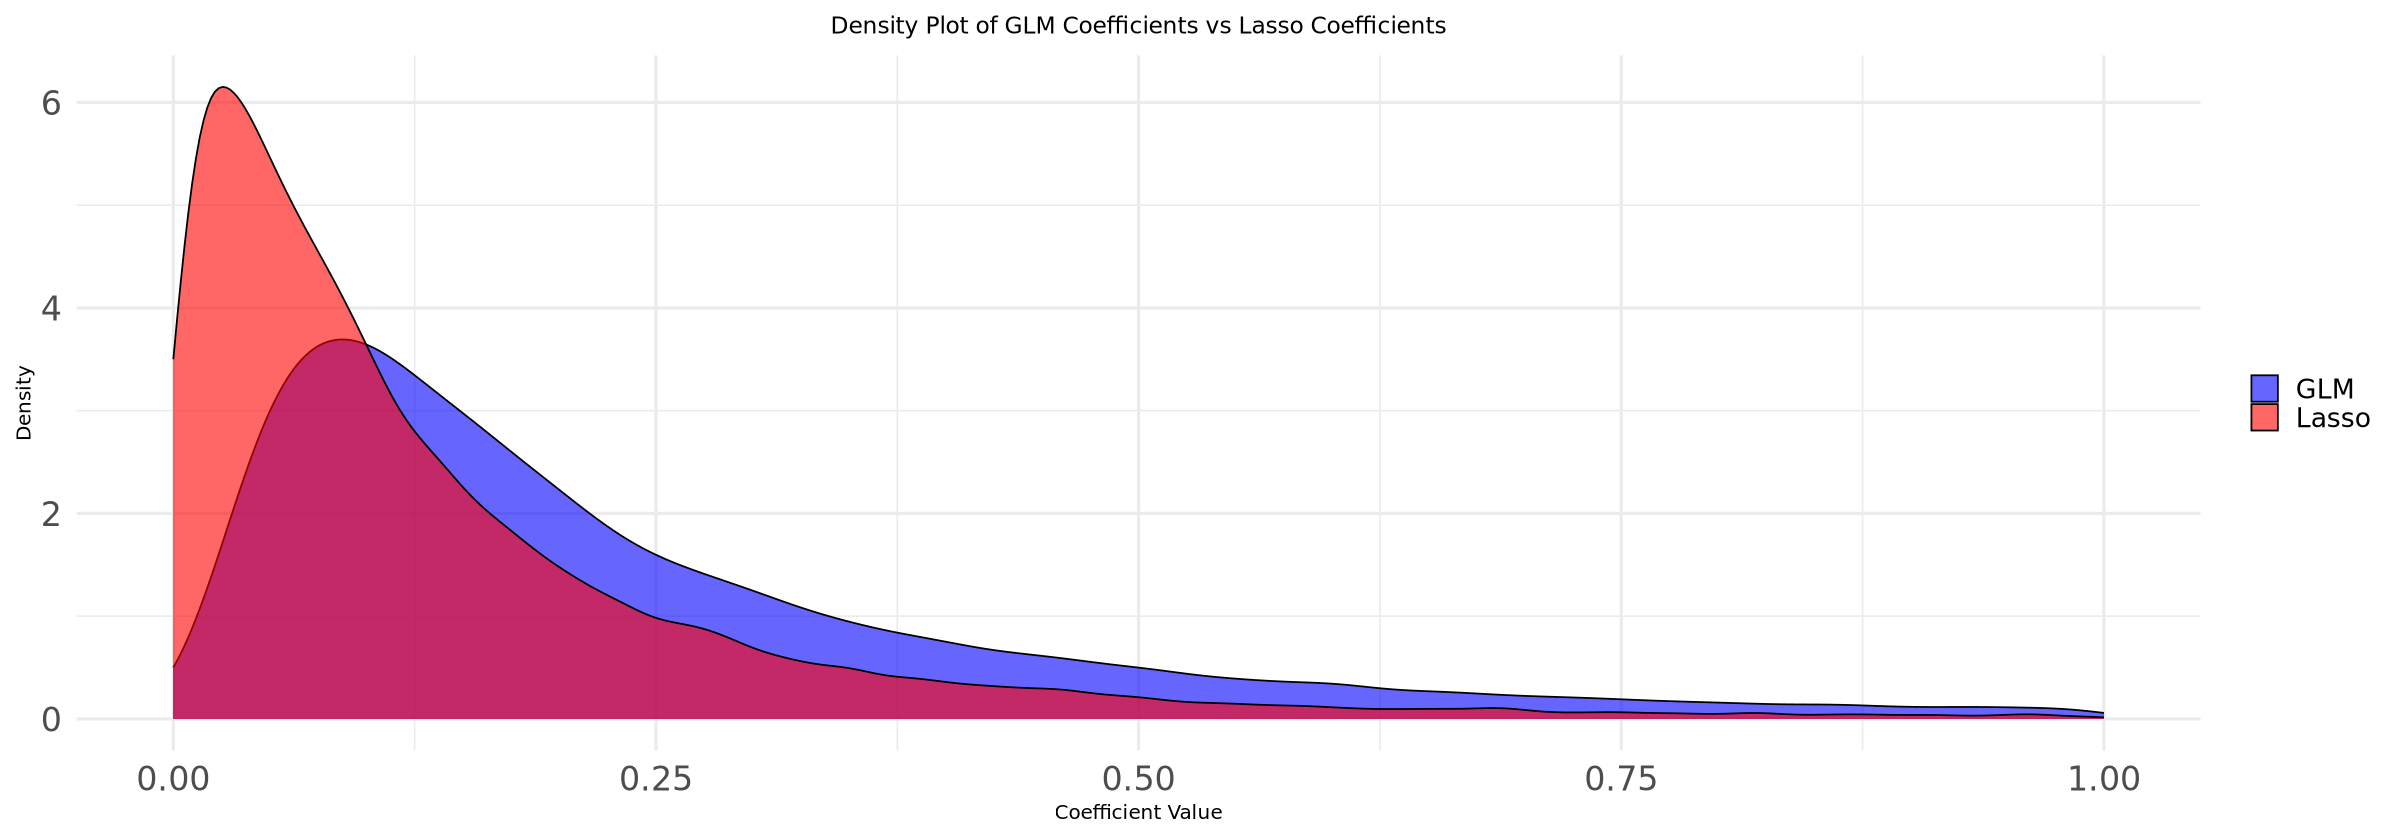

In [58]:
ggplot(filter(peak_gene,is_lasso_selected), aes(x = abs(glm_coef), fill = "GLM")) +
  geom_density(alpha = 0.6) +
  geom_density(aes(x = abs(lasso_coef), fill = "Lasso"), alpha = 0.6) +
  labs(
    title = "Density Plot of GLM Coefficients vs Lasso Coefficients",
    x = "Coefficient Value",
    y = "Density"
  ) +
  scale_fill_manual(values = c("GLM" = "blue", "Lasso" = "red")) +
  theme_minimal(base_size=20) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 20),
    legend.title = element_blank()
  ) + xlim(0,1)

In [75]:
scent_peaks <- read.table("SCENT_no_covariates_output/fibroblast_no_covariate_output.txt",sep=" ",header=T)

In [76]:
scent_peaks$peak <- gsub(":|-",".",scent_peaks$peak)
head(scent_peaks)

,gene,peak,beta,se,z,p,boot_basic_p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TMLHE-AS1,chrX.154980906.154981106,0.21049894,0.08910023,2.3624960,0.018152338,0.1400
2,TMLHE-AS1,chrX.155026708.155026908,0.02261292,0.05045082,0.4482171,0.653996501,0.6200
3,TMLHE-AS1,chrX.155027044.155027244,0.18899768,0.06646660,2.8434985,0.004462121,0.0136
4,TMLHE-AS1,chrX.155027804.155028004,0.13994148,0.07987356,1.7520376,0.079767336,0.1400
5,TMLHE-AS1,chrX.155057440.155057640,0.23564943,0.07064153,3.3358482,0.000850396,0.0216
6,TMLHE-AS1,chrX.155071098.155071298,0.11889394,0.04008823,2.9658068,0.003018901,0.0240


In [77]:
scent_peaks <- scent_peaks %>% select(gene,peak,beta)

In [78]:
colnames(scent_peaks) <- c("gene","peak","scent_coef")

In [79]:
peak_gene <- merge(peak_gene,scent_peaks,by=c("gene","peak"))

In [103]:
colnames(peak_gene)

[1] "gene"              "peak"              "chr"              
 [4] "start"             "end"               "midpoint"         
 [7] "distance_to_tss"   "glm_coef"          "lasso_coef"       
[10] "is_lasso_selected" "gene_count"        "percent_expressed"
[13] "peak_count"        "peak_percent"      "abs_distance"     
[16] "distance_bin"      "scent_beta"        "scent_coef"

In [104]:
corr_data <- peak_gene %>% filter(is_lasso_selected) %>% 
  select(glm_coef, lasso_coef,  scent_coef, distance_to_tss, peak_count, gene_count, percent_expressed, peak_percent)
corr_data$lasso_coef <- abs(corr_data$lasso_coef)
corr_data$glm_coef <- abs(corr_data$glm_coef)
corr_data$scent_coef <- abs(corr_data$scent_coef)

# Calculate correlation matrix
cor_matrix <- cor(corr_data, use = "complete.obs",method="spearman")

In [105]:
cor_matrix

,glm_coef,lasso_coef,scent_coef,distance_to_tss,peak_count,gene_count,percent_expressed,peak_percent
glm_coef,1.0000000,0.817629741,0.6306615,-0.059953499,-0.510575440,-0.23545581,-0.224893034,-0.492280126
lasso_coef,0.8176297,1.000000000,0.6454222,-0.110104557,-0.286821113,-0.01440115,-0.005552041,-0.262857483
scent_coef,0.6306615,0.645422190,1.0000000,-0.112652872,-0.473845364,-0.11911519,-0.109030382,-0.456674452
distance_to_tss,-0.0599535,-0.110104557,-0.1126529,1.000000000,0.005385296,-0.01889730,-0.018567236,0.002674251
peak_count,-0.5105754,-0.286821113,-0.4738454,0.005385296,1.000000000,-0.08953530,-0.098834033,0.988213029
gene_count,-0.2354558,-0.014401147,-0.1191152,-0.018897299,-0.089535299,1.00000000,0.992920783,-0.088095118
percent_expressed,-0.2248930,-0.005552041,-0.1090304,-0.018567236,-0.098834033,0.99292078,1.000000000,-0.096692605
peak_percent,-0.4922801,-0.262857483,-0.4566745,0.002674251,0.988213029,-0.08809512,-0.096692605,1.000000000


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


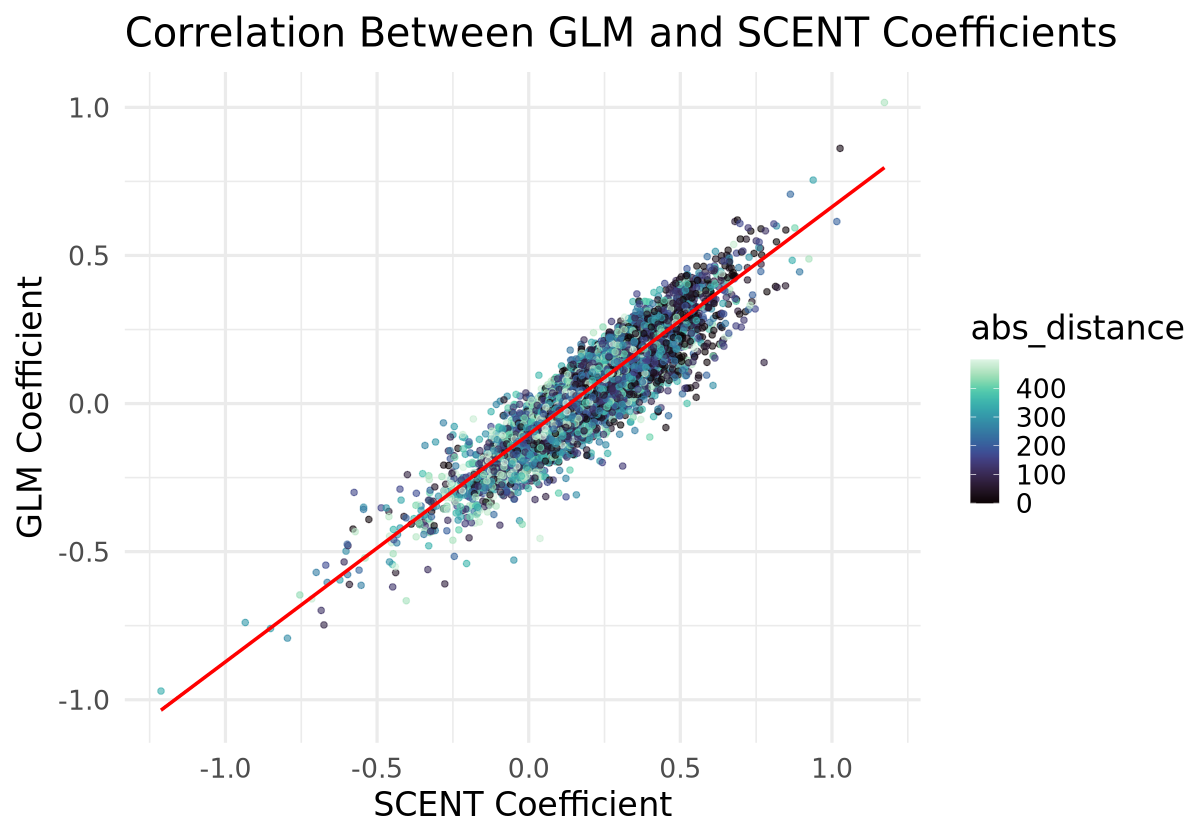

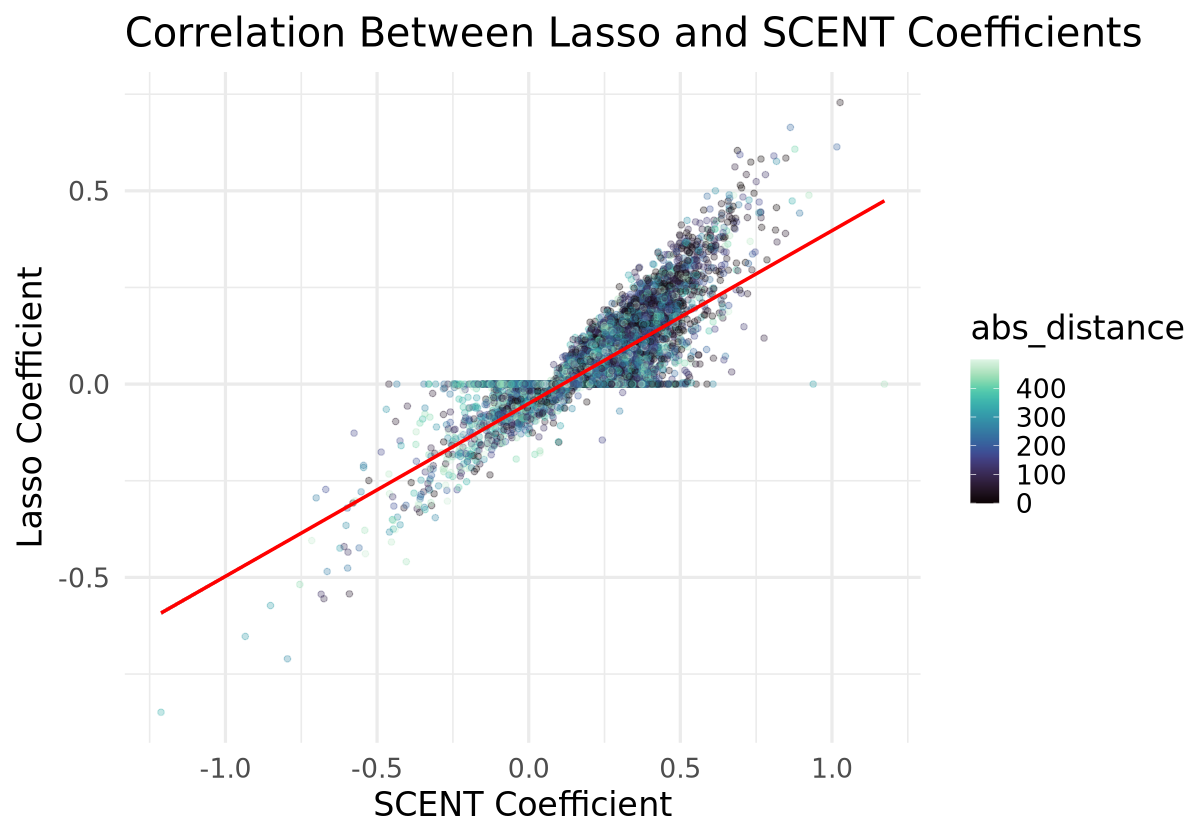

In [106]:
library(viridis)
ggplot(peak_gene, aes(y = glm_coef, x = scent_beta, color = abs_distance)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", color = "red", se = TRUE) +
  labs(title = "Correlation Between GLM and SCENT Coefficients",
       y = "GLM Coefficient", 
       x = "SCENT Coefficient") +
  #scale_color_manual(values = c("TRUE" = "blue", "FALSE" = "gray")) +
  scale_color_viridis(option="G")+
  theme_minimal(base_size=20)

ggplot(peak_gene, aes(y = lasso_coef, x = scent_beta, color = abs_distance)) +
  geom_point(alpha = 0.3) +
  geom_smooth(method = "lm", color = "red", se = TRUE) +
  labs(title = "Correlation Between Lasso and SCENT Coefficients",
       y = "Lasso Coefficient", 
       x = "SCENT Coefficient") +
       #scale_color_gradient(low = "dodgerblue2", high = "red")+
       scale_color_viridis(option="G")+
  #scale_color_manual(values = c("TRUE" = "blue", "FALSE" = "gray")) +
  theme_minimal(base_size=20)


In [319]:
install.packages("corrplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [72]:
library(corrplot)

corrplot 0.95 loaded



In [327]:
cor_matrix

,glm_coef,lasso_coef,distance_to_tss,peak_count,gene_count
glm_coef,1.000000000,0.763994495,0.002285901,-0.711706391,-0.321724657
lasso_coef,0.763994495,1.000000000,0.003245068,-0.432141204,-0.134273340
distance_to_tss,0.002285901,0.003245068,1.000000000,-0.007094494,-0.009575193
peak_count,-0.711706391,-0.432141204,-0.007094494,1.000000000,-0.056402316
gene_count,-0.321724657,-0.134273340,-0.009575193,-0.056402316,1.000000000


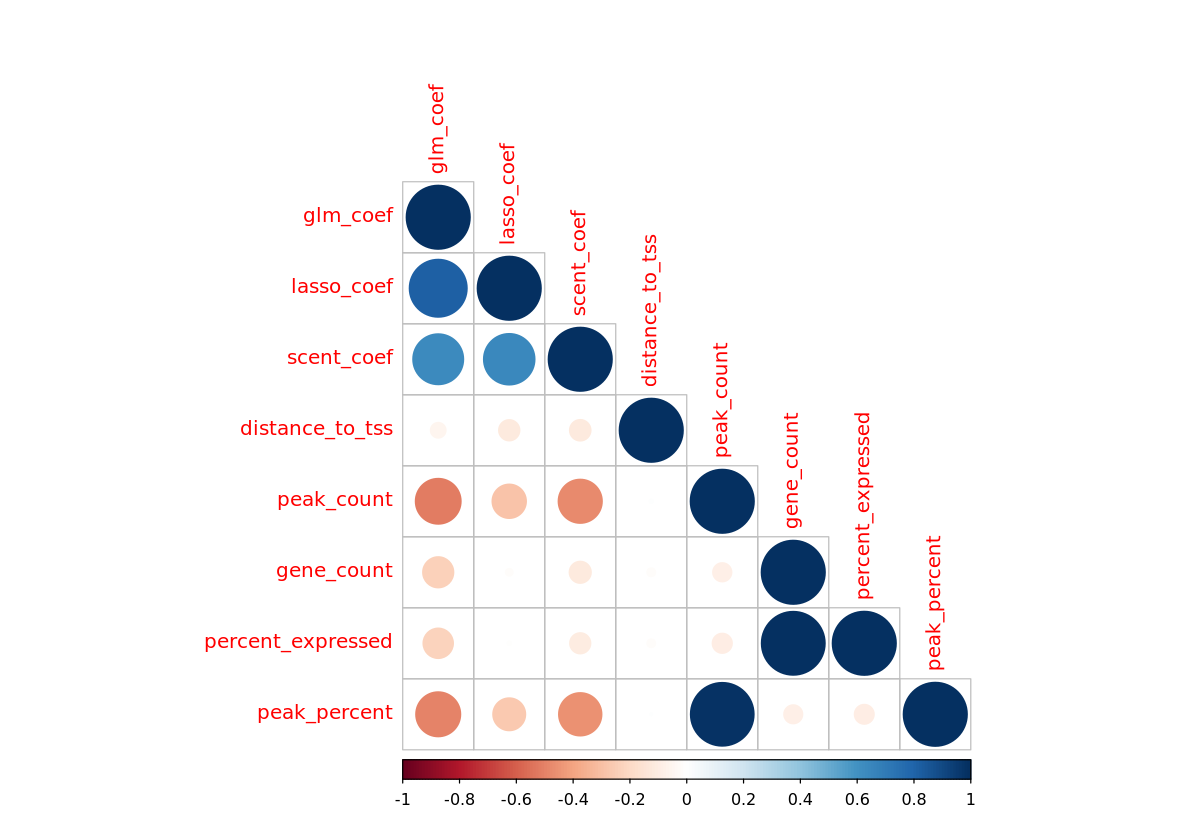

In [107]:
corrplot(cor_matrix,diag=TRUE,type = 'lower')